In [50]:
################################# Header files ########################################################
from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2

import pandas as pd
import sys
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Conv2D, Dropout, Flatten
from keras import optimizers, utils, initializers, regularizers
import keras.backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler #Importing the StandardScaler

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.stats import pearsonr
from math import sqrt

#Geo plotting libraries
#import geopandas as gdp
#from matplotlib.colors import ListedColormap
#import geoplot as glpt

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold
import matplotlib.lines as mlines
import folium
import glob

from statistics import mean

pd.options.display.max_columns = None

print("Done uploading repositories")

Done uploading repositories


In [51]:
################# UCI Beijing dataset (2013 - 2017) #####################################################################
############### Spacio-temporal dataset. (multi-year and multi-terrain)
# beijing_aqi_df = pd.read_csv('AQI_datasets/Beijing_AQI/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv') 
# drop_index = ['No']
# beijing_aqi_df = beijing_aqi_df.drop(drop_index, axis=1)
# #print(beijing_aqi_df.head())
# print(beijing_aqi_df.isnull().sum())

path_beijing = r'AQI_datasets/Beijing_AQI/PRSA_Data_20130301-20170228/' ## Path for all the files
allFiles = glob.glob(path_beijing + "/*.csv")
beijing_aqi_df = pd.DataFrame()
list_beijing = []
for file_ in allFiles:
    temp_df = pd.read_csv(file_, index_col = None, header=0)
    list_beijing.append(temp_df)
beijing_aqi_df = pd.concat(list_beijing)

cols = ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

beijing_aqi_df = beijing_aqi_df[cols]

drop_index = ['No']
beijing_aqi_df = beijing_aqi_df.drop(drop_index, axis=1)

beijing_aqi_df = beijing_aqi_df.sort_values(['station', 'year'])

beijing_aqi_df.head(20)
# beijing_aqi_df.year.value_counts()
# beijing_aqi_df.wd.value_counts()
# beijing_aqi_df.shape
# beijing_aqi_df['station'].nunique()

## O3: Dependent, Predictors: SO2, NO2, year, month, CO
## PM25: Dependent, Predictors:


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
5,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,N,3.7,Aotizhongxin
6,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,NNE,2.5,Aotizhongxin
7,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,NNW,3.8,Aotizhongxin
8,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,NNW,4.1,Aotizhongxin
9,2013,3,1,9,3.0,8.0,12.0,28.0,400.0,59.0,1.2,1028.5,-19.3,0.0,N,2.6,Aotizhongxin


In [52]:
## Seperate the dataset into predictors and target variable.
predictors = ['year', 'month', 'SO2', 'NO2', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'O3']
beijing_predictors_df = beijing_aqi_df[predictors]
wd_codes = {'N':1, 'E': 2, 'W': 3, 'S': 4, 'NE': 5, 'NW': 6, 'SE': 7, 'SW': 8, 'NNE': 9, 'NNW': 10, 'SSE': 11, 
            'SSW': 12, 'WNW': 13, 'WSW': 14, 'ENE': 15, 'ESE': 16 }
beijing_predictors_df.replace(wd_codes, inplace=True)
beijing_predictors_df.wd.value_counts()
beijing_predictors_df

# target = ['O3']
# beijing_target_df = beijing_aqi_df[target]
# beijing_target_df


/Users/shrey/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,O3
0,2013,3,4.0,7.0,300.0,-0.7,1023.0,-18.8,0.0,10.0,4.4,Aotizhongxin,77.0
1,2013,3,4.0,7.0,300.0,-1.1,1023.2,-18.2,0.0,1.0,4.7,Aotizhongxin,77.0
2,2013,3,5.0,10.0,300.0,-1.1,1023.5,-18.2,0.0,10.0,5.6,Aotizhongxin,73.0
3,2013,3,11.0,11.0,300.0,-1.4,1024.5,-19.4,0.0,6.0,3.1,Aotizhongxin,72.0
4,2013,3,12.0,12.0,300.0,-2.0,1025.2,-19.5,0.0,1.0,2.0,Aotizhongxin,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,3.0,24.0,400.0,12.5,1013.5,-16.2,0.0,6.0,2.4,Wanshouxigong,72.0
35060,2017,2,3.0,41.0,500.0,11.6,1013.6,-15.1,0.0,13.0,0.9,Wanshouxigong,50.0
35061,2017,2,4.0,38.0,500.0,10.8,1014.2,-13.3,0.0,6.0,1.1,Wanshouxigong,54.0
35062,2017,2,4.0,30.0,400.0,10.5,1014.4,-12.9,0.0,10.0,1.2,Wanshouxigong,59.0


In [53]:
############# Replacing missing values ##############################################################
beijing_predictors_df = beijing_predictors_df.dropna(axis=0) # , subset=['O3'])

###### percentage of missing values in each column #####################################3
round(beijing_predictors_df.isna().sum()/len(beijing_predictors_df.index), 2)*100

year       0.0
month      0.0
SO2        0.0
NO2        0.0
CO         0.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
O3         0.0
dtype: float64

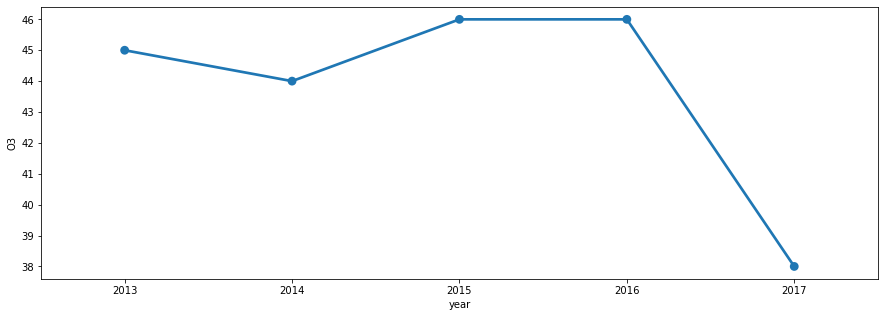

In [54]:
###### plotting concentration of PM 2.5 values over the years ###############################
df_plot_beijing = beijing_predictors_df[['O3','year','station']].groupby(["year"]).median().reset_index().sort_values(by = 'year',ascending=False)
f,ax = plt.subplots(figsize = (15,5))
sns.pointplot(x = 'year', y = 'O3', data = df_plot_beijing)

In [55]:
##Get correlation between O3 and other predictors
# corrMatrix_beijing = beijing_aqi_df.corr()
corrMatrix_beijing = beijing_predictors_df.corr()
corrMatrix_beijing["O3"].sort_values(ascending=False)


O3       1.000000
TEMP     0.597431
DEWP     0.313067
WSPM     0.296701
wd       0.056912
RAIN     0.023375
year    -0.021672
month   -0.101012
SO2     -0.166692
CO      -0.314770
PRES    -0.447751
NO2     -0.476478
Name: O3, dtype: float64

In [56]:
### Drop stations (dropping stations at this stage so more combination of splits can be made later) ###############
drop_stations = ['station']
beijing_predictors_df = beijing_predictors_df.drop(drop_stations, axis=1)

## Splitting the dataset by the year ##############
beijing_predictors_df.year.value_counts()
beijing_predictors_df_target = beijing_predictors_df[beijing_predictors_df['year'].isin([2014, 2015])]
beijing_predictors_df_source = beijing_predictors_df[beijing_predictors_df['year'].isin([2016])]

beijing_predictors_df_source.shape
beijing_predictors_df_target.head(10)


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,O3
7345,2014,1,25.0,91.0,1100.0,-2.6,1006.9,-12.1,0.0,14.0,0.2,1.0
7346,2014,1,41.0,103.0,1800.0,-3.0,1006.9,-11.3,0.0,14.0,0.6,1.0
7347,2014,1,43.0,101.0,2100.0,-3.3,1006.4,-11.1,0.0,8.0,0.6,1.0
7348,2014,1,59.0,130.0,2400.0,-2.7,1006.1,-10.5,0.0,15.0,1.8,1.0
7349,2014,1,47.0,102.0,2500.0,-3.1,1006.6,-10.4,0.0,1.0,1.0,1.0
7350,2014,1,45.0,91.0,1900.0,-2.6,1007.2,-10.9,0.0,4.0,1.0,1.0
7351,2014,1,24.0,69.0,900.0,-2.9,1007.9,-10.2,0.0,7.0,1.1,4.0
7352,2014,1,18.0,52.0,700.0,0.0,1008.8,-8.5,0.0,3.0,1.5,17.0
7353,2014,1,25.0,87.0,1200.0,9.0,1009.6,-11.6,0.0,10.0,1.9,1.0
7354,2014,1,27.0,63.0,1200.0,10.3,1009.4,-11.7,0.0,10.0,1.7,16.0


In [57]:
##Standardize the dataset.

cols_to_norm = ['SO2', 'NO2', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

ss = StandardScaler()
beijing_predictors_df_target[cols_to_norm] = ss.fit_transform(beijing_predictors_df_target[cols_to_norm])
beijing_predictors_df_source[cols_to_norm] = ss.fit_transform(beijing_predictors_df_source[cols_to_norm])



<ipython-input-57-a047f75d3bc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beijing_predictors_df_target[cols_to_norm] = ss.fit_transform(beijing_predictors_df_target[cols_to_norm])
/Users/shrey/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-57-a047f75d3bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [58]:
###Splitting the dataset into train and test set ########
target_beijing_col = ['O3']
beijing_predictors_df_target_Y = beijing_predictors_df_target[target_beijing_col]
beijing_predictors_df_target_X = beijing_predictors_df_target.drop(target_beijing_col, axis =1)

beijing_predictors_df_source_Y = beijing_predictors_df_source[target_beijing_col]
beijing_predictors_df_source_X = beijing_predictors_df_source.drop(target_beijing_col, axis =1)


X_train, X_test, y_train, y_test = train_test_split(beijing_predictors_df_target_X, beijing_predictors_df_target_Y, test_size = 0.999, random_state = 1)

X_source = beijing_predictors_df_source_X
y_source = beijing_predictors_df_source_Y

X_source['O3'] = y_source
X_train['O3'] = y_train
X_test['O3'] = y_test

X_train.shape, X_test.shape, X_source.shape, y_train.shape
X_test
X_train

<ipython-input-58-778fb603e673>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['O3'] = y_train
<ipython-input-58-778fb603e673>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['O3'] = y_test


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,O3
12120,2014,7,-0.633920,-0.123149,0.293173,1.235786,-1.182308,1.573586,-0.078282,13.0,-1.392710,129.0
24343,2015,12,0.403135,1.148601,3.002817,-1.237794,0.942163,-0.224911,-0.078282,5.0,-0.251008,9.0
12664,2014,8,-0.633920,-0.942721,-0.638267,1.889518,-1.936152,0.606894,-0.078282,14.0,1.787746,209.0
19949,2015,6,-0.590710,-0.631849,-0.214885,0.396536,-1.495594,1.064012,-0.078282,15.0,-0.821859,60.0
10881,2014,5,0.100661,2.250784,-0.384238,1.518481,-1.192098,0.082332,-0.078282,8.0,0.646044,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14943,2014,11,-0.504288,-0.631849,-0.722944,-0.080512,0.511395,-1.079198,-0.078282,14.0,-0.169457,60.0
17596,2015,3,-0.633920,-1.394899,-0.807620,-1.820852,0.775730,-1.881028,-0.078282,14.0,-0.577208,64.0
7515,2014,1,-0.288235,-0.999243,-0.722944,-1.405644,1.793909,-1.828572,-0.078282,5.0,0.646044,53.0
12748,2014,8,-0.633920,-0.066627,-0.638267,0.299359,-0.771120,1.078999,-0.078282,15.0,-0.495658,5.0


In [59]:
######################################## Seeding Technique ###################################################
kmeans = KMeans(n_clusters = 20, random_state=0).fit(X_source)

Alternate_df = X_train.copy()
idxlist = []
Alternate_df_np = Alternate_df.to_numpy()

new_df_list = []


for rowkm in kmeans.cluster_centers_:
    mindist = -99
    rowidx = 0
    idx = 0
    for row in Alternate_df_np:
        dst = distance.euclidean(row, rowkm)

        if(dst >= mindist):
            mindist = dst
            rowidx = idx
            rowval = row

        idx = idx + 1

    print("Row selected: ", rowidx) #Alternate_df.loc[rowidx,:]\
    print("Min. distance: ", mindist)
    print("Matrix shape: ", Alternate_df_np.shape)
    new_df_list.append(rowval)
    Alternate_df_np = np.delete(Alternate_df_np, rowidx, 0)
    idxlist.append(rowidx)


new_df = pd.DataFrame(np.vstack(new_df_list))
#new_df
new_df.shape
#new_df.dtypes



Row selected:  165
Min. distance:  197.83732724268395
Matrix shape:  (197, 12)
Row selected:  175
Min. distance:  210.66800360031093
Matrix shape:  (196, 12)
Row selected:  110
Min. distance:  191.86603309082236
Matrix shape:  (195, 12)
Row selected:  112
Min. distance:  146.28902827357595
Matrix shape:  (194, 12)
Row selected:  69
Min. distance:  171.26843142953635
Matrix shape:  (193, 12)
Row selected:  22
Min. distance:  310.57851110985115
Matrix shape:  (192, 12)
Row selected:  52
Min. distance:  216.56505138531477
Matrix shape:  (191, 12)
Row selected:  35
Min. distance:  111.1667161894014
Matrix shape:  (190, 12)
Row selected:  149
Min. distance:  219.14780726634962
Matrix shape:  (189, 12)
Row selected:  10
Min. distance:  175.89249390388852
Matrix shape:  (188, 12)
Row selected:  2
Min. distance:  124.06255739258464
Matrix shape:  (187, 12)
Row selected:  102
Min. distance:  198.36002381993347
Matrix shape:  (186, 12)
Row selected:  37
Min. distance:  137.24265665403266
Matrix 

(20, 12)

In [60]:
##################################################### Phase 2: Seeding ################################################

alt_source_df = X_source.copy()
idxlist2 = []
alt_source_df_np = alt_source_df.to_numpy()

final_df_list = []

for row_nm in new_df_list:
    min_dist = -99
    row_idx = 0
    idx_val = 0
    for row_alt in alt_source_df_np:
        dst = distance.euclidean(row_alt, row_nm)
        if(dst >= mindist):
            min_dist = dst
            row_idx = idx_val
            row_val = row_alt

        idx_val = idx_val + 1

    print("Row selected: ", row_idx) #Alternate_df.loc[rowidx,:]\
    print("Min. distance: ", min_dist)
    print("Matrix shape: ", alt_source_df_np.shape)
    final_df_list.append(row_val)
    alt_source_df_np = np.delete(alt_source_df_np, row_idx, 0)
    idxlist2.append(row_idx)


final_df = pd.DataFrame(np.vstack(final_df_list), columns= X_source.columns)
final_df
final_df.shape

print("Shape before :",X_source.shape)
X_source = pd.concat([X_source, final_df])
X_source = X_source.drop_duplicates(keep=False)
print("Shape after :",X_source.shape)

Row selected:  99614
Min. distance:  264.14640633546503
Matrix shape:  (99615, 12)
Row selected:  24683
Min. distance:  274.20512395255156
Matrix shape:  (99614, 12)
Row selected:  96540
Min. distance:  282.2112704198866
Matrix shape:  (99613, 12)
Row selected:  96539
Min. distance:  297.1417052177414
Matrix shape:  (99612, 12)
Row selected:  20957
Min. distance:  280.0347257417264
Matrix shape:  (99611, 12)
Row selected:  96126
Min. distance:  269.5605416696099
Matrix shape:  (99610, 12)
Row selected:  20953
Min. distance:  280.0087948575396
Matrix shape:  (99609, 12)
Row selected:  96124
Min. distance:  291.08463227969264
Matrix shape:  (99608, 12)
Row selected:  96123
Min. distance:  271.26945189262426
Matrix shape:  (99607, 12)
Row selected:  20952
Min. distance:  287.04412822940407
Matrix shape:  (99606, 12)
Row selected:  20129
Min. distance:  291.2752360570831
Matrix shape:  (99605, 12)
Row selected:  0
Min. distance:  -99
Matrix shape:  (99604, 12)
Row selected:  0
Min. distanc

In [61]:
X_train = pd.concat([X_train, final_df], ignore_index=True)

X_train.to_csv('ActiveSampling/B_O3_seeded_train.csv',index=False)
X_source.to_csv('ActiveSampling/B_O3_seeded_source.csv',index=False)

# X_train.to_csv('ActiveSampling/UCI_NO2_activesampling_train.csv',index=False)
# X_source.to_csv('ActiveSampling/UCI_NO2_activesampling_source.csv',index=False)
# X_test.to_csv('ActiveSampling/UCI_NO2_activesampling_test.csv',index=False)

In [62]:
X_train = pd.read_csv('ActiveSampling/B_O3_seeded_train.csv')
X_source = pd.read_csv('ActiveSampling/B_O3_seeded_source.csv')

X_source['ManDis'] = 0.0

train_df_mean = []
prow = X_train.mean()
train_df_mean = [prow.year, prow.month, prow.SO2, prow.NO2, prow.CO, prow.TEMP, prow.PRES, prow.DEWP, prow.wd, prow.WSPM, prow.O3]

rowidx = 0
for row in X_source.itertuples():
    row_list =[row.year, row.month, row.SO2, row.NO2, row.CO, row.TEMP, row.PRES, row.DEWP, row.wd, row.WSPM, row.O3]

    man_dis = 0
    for i in range(0, len(row_list)):
        tempval = train_df_mean[i] - row_list[i]
        man_dis = man_dis + abs(tempval)
    
    X_source.loc[rowidx,"ManDis"] = man_dis
    # print(Source_df.loc[rowidx,"ManDis"])
    rowidx = rowidx + 1


X_source_rest = X_source.sort_values('ManDis')
X_source = X_source.head(12000)
X_source_rest = X_source.iloc[12000:]
X_source_rest = X_source_rest.drop(['ManDis'], axis =1)
X_source = X_source.drop(['ManDis'], axis =1)

X_train.to_csv('ActiveSampling/Beijing_O3_activesampling_train.csv',index=False)
X_source.to_csv('ActiveSampling/Beijing_O3_activesampling_source.csv',index=False)
X_test.to_csv('ActiveSampling/Beijing_O3_activesampling_test.csv',index=False)

print("Done !!!!!")
X_source

Done !!!!!


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,O3
0,2016.0,1.0,2.772768,2.280143,3.743354,-1.336244,1.225578,-0.707968,-0.084862,9.0,-0.618369,13.0
1,2016.0,1.0,4.193714,2.160704,3.833436,-1.420293,1.160356,-0.644751,-0.084862,5.0,-0.699815,16.0
2,2016.0,1.0,4.044141,2.041265,2.842532,-1.521150,1.151039,-0.644751,-0.084862,15.0,-0.862708,12.0
3,2016.0,1.0,3.445848,1.921827,2.662368,-1.428697,1.095134,-0.672847,-0.084862,15.0,-0.292584,9.0
4,2016.0,1.0,2.697982,1.802388,2.211957,-1.554769,1.020595,-0.672847,-0.084862,2.0,-0.699815,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2016.0,6.0,-0.592630,-0.287787,-0.400425,0.546432,-0.768355,1.174477,-0.084862,12.0,-1.107047,37.0
11996,2016.0,6.0,-0.592630,0.488564,-0.400425,0.546432,-0.786990,1.209597,-0.084862,10.0,-0.699815,25.0
11997,2016.0,6.0,-0.592630,0.279546,-0.400425,0.538027,-0.796307,1.188525,-0.084862,1.0,-0.455476,22.0
11998,2016.0,6.0,-0.592630,0.249686,-0.400425,0.529622,-0.777672,1.181501,-0.084862,4.0,-0.781261,14.0


In [3]:
list1 = ["M", "na", "i", "Ke"] 
list2 = ["y", "me", "s", "lly"]
list3 = []
for i, j in zip(list1, list2):
    list3.append(i + j)
print(list3)


['My', 'name', 'is', 'Kelly']
